In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import astropy.units as u
from astropy.time import Time
import datetime
from scipy import interpolate
from scipy import optimize

The track of DSLWP-B in Lunar latitude, longitude and altitude bewteen 14:18 and 14:22UTC on July 31st, 2019 was provided by MingChuan Wei by email on August 1st. 

It is not clear with Lunar model is used for this. For the following, I will assume the model is spherical and has a radius of 1737.4 km.

The following commands read the satellite track, and renames some of the columns, as well as adding units.

In [2]:
p = ascii.read("DSLWP-B1-MOON_LLA_Position.csv")
p.rename_column("Time (UTCG)", "time")
p.rename_column("Lat (deg)", "b")
p.rename_column("Lon (deg)", "l")
p.rename_column("Alt (km)", "alt")
p["b"].unit = u.deg
p["l"].unit = u.deg
p["alt"].unit = u.km

The time stamps in the file are converted to `astropy` `Time` objects.

In [3]:
tisot = []
for i, pt in enumerate(p["time"]):
    tisot.append(datetime.datetime.strptime(pt.replace(".000", ""), "%d %b %Y %H:%M:%S").strftime("%Y-%m-%dT%H:%M:%S"))
p["time"] = Time(tisot, format="isot", scale="utc")

A rough estimate of the impact location can be found by taking the track value with the altitude closest to zero.

In [4]:
i = np.argmin(np.abs(p["alt"]))
limpact, bimpact = p["l"][i], p["b"][i]
print("Approximate impact location ", p[i])

Approximate impact location            time            b      l      alt    Lat Rate (deg/sec) Lon Rate (deg/sec) Alt Rate (km/sec)
                         deg    deg      km                                                           
----------------------- ----- ------- -------- ------------------ ------------------ -----------------
2019-07-31T14:20:11.000 16.51 159.326 -0.14569           0.037273           0.065535         -0.395695


A digital elevation model (DEM) is available from http://pds-geosciences.wustl.edu/lro/lro-l-lola-3-rdr-v1/lrolol_1xxx/data/sldem2015/tiles/float_img/. This data is based on LRO and SELENE data. The following parameters describe the data file covering the DSLWP-B impact location at 512 pixels per degree in cylindrical coordinates.

In [5]:
nb, nl = 15360, 23040
bmin, bmax = 0.0, 30.0
lmin, lmax = 135.0, 180.0
alt = np.flipud(np.fromfile("sldem2015_512_00n_30n_135_180_float.img", dtype="float32").reshape(nb, nl))

We can now plot the DEM and overlay the satellite track. The esimated impact point is inside a crater, which Phil Stooke has identified as close to 'van Gent' crater (http://www.unmannedspaceflight.com/index.php?showtopic=8057&st=240&start=240)

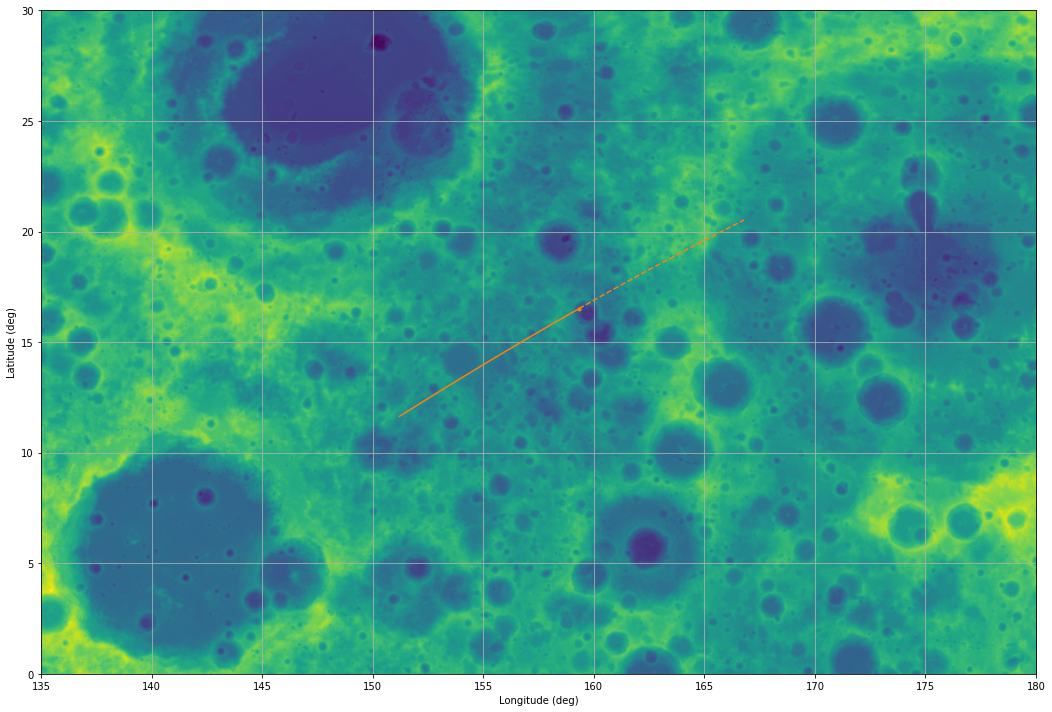

In [6]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(alt, extent=[lmin, lmax, bmin, bmax], origin="lower")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
c = p["l"]<limpact
ax.plot(p["l"][c], p["b"][c], "C1")
ax.plot(p["l"][~c], p["b"][~c], "C1--")
ax.plot(limpact, bimpact, "C1.")
ax.grid()
plt.tight_layout()
plt.savefig("fullmap.png", bbox_inches="tight")

Since the full map is too large to perform 2D interpolation to find the surface altitude along the satellite track, I first select the relevant part of the map.

In [7]:
l = np.linspace(lmin, lmax, nl, endpoint=False)
b = np.linspace(bmin, bmax, nb, endpoint=False)

In [8]:
lcmin, lcmax = 152.0, 164.0
bcmin, bcmax = 11.0, 21.0

In [9]:
imin = int(nl*(lcmin-lmin)/(lmax-lmin))
imax = int(nl*(lcmax-lmin)/(lmax-lmin))
jmin = int(nb*(bcmin-bmin)/(bmax-bmin))
jmax = int(nb*(bcmax-bmin)/(bmax-bmin))
nlc = imax-imin
nbc = jmax-jmin

In [10]:
lc = np.linspace(lcmin, lcmax, nlc, endpoint=False)
bc = np.linspace(bcmin, bcmax, nbc, endpoint=False)
altc = alt[jmin:jmax, imin:imax]

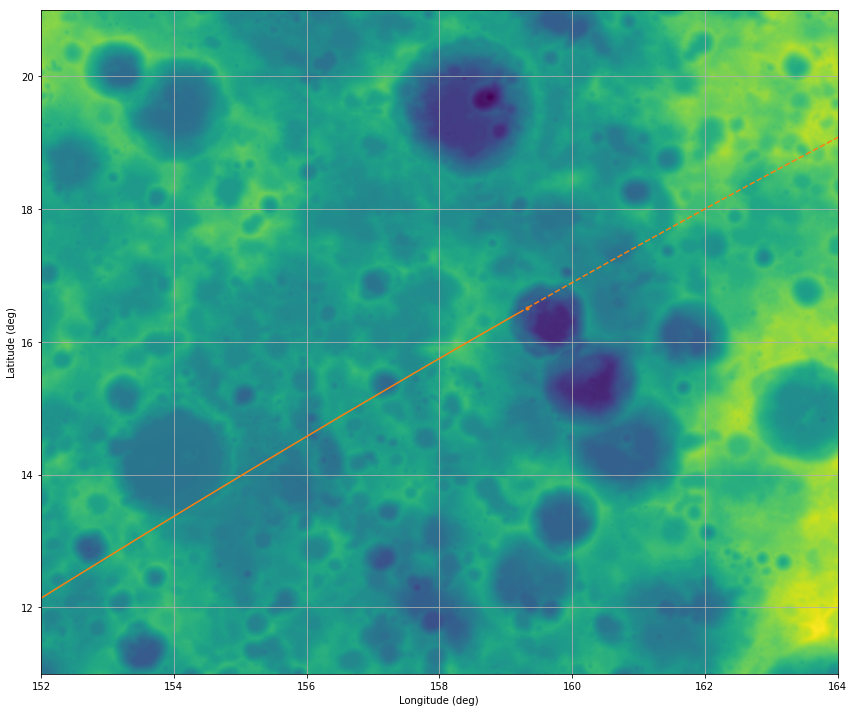

In [11]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(altc, extent=[lcmin, lcmax, bcmin, bcmax], origin="lower")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
c = p["l"]<limpact
ax.plot(p["l"][c], p["b"][c], "C1")
ax.plot(p["l"][~c], p["b"][~c], "C1--")
ax.plot(limpact, bimpact, "C1.")
ax.set_xlim(lcmin, lcmax)
ax.set_ylim(bcmin, bcmax)
ax.grid()
plt.tight_layout()
plt.savefig("impact_guess.png", bbox_inches="tight")

For each longitude, we can now interpolate the satellite latitude and altitude from the satellite track, as well as interpolate the surface altitude from the DEM.

In [12]:
# Interpolate lunar surface altitude
alt_surface = np.zeros_like(lc)
alt_sat = np.zeros_like(lc)
bsat = np.zeros_like(lc)
fint_bsat = interpolate.interp1d(p["l"], p["b"])
fint_altsat = interpolate.interp1d(p["l"], p["alt"])
for i, l0 in enumerate(lc):
    # Get satellite latitude
    bsat[i] = fint_bsat(l0)
    
    # Get satellite altitude
    alt_sat[i] = fint_altsat(l0)
    
    # Set up interpolating function for surface altitude
    fint_altsurface = interpolate.interp1d(bc, altc[:, i])
    
    alt_surface[i] = fint_altsurface(bsat[i])

To plot the satellite and surface altitude, it is more sensible to compute range across the surface, to provide a sense of scale.

In [13]:
# Estimate downrange distance
rmoon = 1737.4*u.km
alpha = np.arccos(np.sin(bsat*u.deg)*np.sin(bimpact*u.deg)+np.cos(bsat*u.deg)*np.cos(bimpact*u.deg)*np.cos((lc-limpact)*u.deg))
downrange = alpha.to(u.rad)*rmoon
downrange[lc<limpact] *= -1

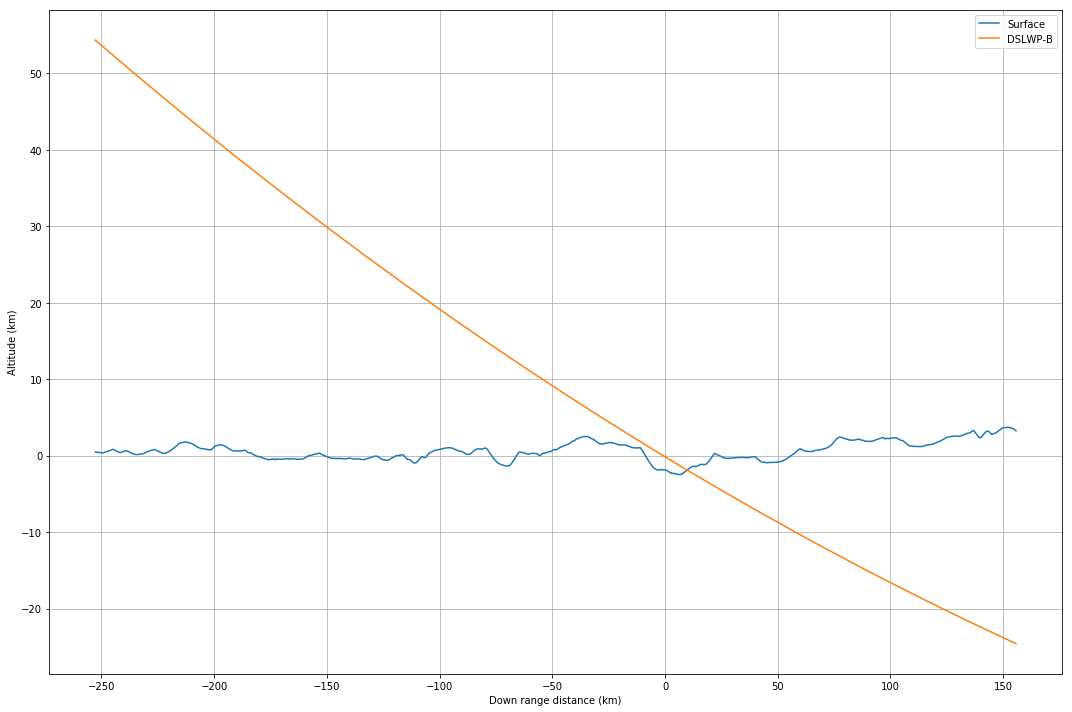

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(downrange, alt_surface, label="Surface")
ax.plot(downrange, alt_sat, label="DSLWP-B")
ax.set_xlabel("Down range distance (km)")
ax.set_ylabel("Altitude (km)")
ax.grid()
ax.legend()
plt.tight_layout()
plt.savefig("surface.png", bbox_inches="tight")

With the satellite and surface altitude defined along longitude, we can estimate where the actual impact point of this track is located. Again, we interpolate along both tracks.

In [15]:
falt = interpolate.interp1d(lc, alt_sat-alt_surface)
fbsat = interpolate.interp1d(lc, bsat)
limpact_best = optimize.bisect(falt, 158.0, 162.0)
bimpact_best = fbsat(limpact_best)
print("Best impact location: %.3f deg East, %.3f deg North" % (limpact_best, bimpact_best))

Best impact location: 159.617 deg East, 16.675 deg North


This shows that due to the crater, the actual impact location is about 10 km further down range compared to the location where the satellite would have impacted the spherical surface.

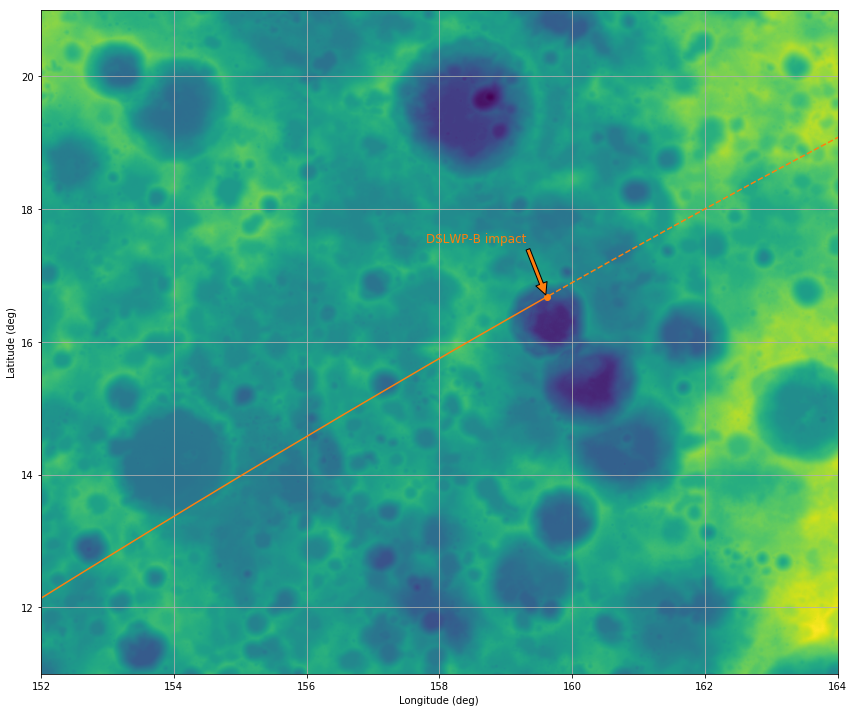

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(altc, extent=[lcmin, lcmax, bcmin, bcmax], origin="lower")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
c = p["l"]<limpact_best
ax.plot(p["l"][c], p["b"][c], "C1")
ax.plot(p["l"][~c], p["b"][~c], "C1--")
ax.plot(limpact_best, bimpact_best, "C1o")
ax.set_xlim(lcmin, lcmax)
ax.set_ylim(bcmin, bcmax)
ax.grid()
ax.annotate("DSLWP-B impact", xy=(limpact_best, bimpact_best), xytext=(157.8, 17.5), color="C1", fontsize='large', arrowprops=dict(facecolor="C1", shrink=0.04))
plt.tight_layout()
plt.savefig("impact_best.png", bbox_inches="tight")